## Imports

In [2]:
import numpy as np
import einops
import copy
import matplotlib
import matplotlib.pyplot as plt


from scipy.spatial import ckdtree
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint

from shapely.geometry.polygon import Polygon
import shapely
from shapely import affinity

import importlib

In [3]:
import bonds
import lattice
import utils
import plot_utils

In [4]:
bonds = importlib.reload(bonds)
lattice = importlib.reload(lattice)
utils = importlib.reload(utils)


## Set up lattice

### Kagome bow tie

In [5]:
# lattice params for kagome lattice
nx = 8
ny = 8
grid_params = {'x1':0, 'x2':nx, 'y1':0, 'y2':ny, 'Nx':nx, 'Ny':ny, 
               'a1':np.array([2,0]), 'a2':np.array([1, np.sqrt(3)]), 'O':(0., 0.),
               'unit_cell_bases':[np.array([1/2, 0]), np.array([-1/2, 0]), np.array([0, np.sqrt(3)/2.])]  
                                 }
mesh = lattice.create_grid_mesh(grid_params)
BZ_kpoints = lattice.create_grid(grid_params)
my_x, my_y = zip((BZ_kpoints[:, 0], BZ_kpoints[:, 1]))

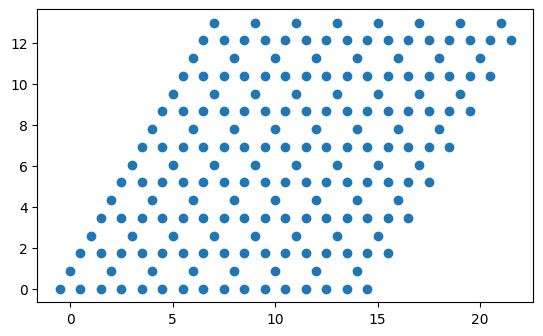

In [6]:
fig, ax = plt.subplots(1,1)
my_x, my_y = lattice.convert_to_XY(BZ_kpoints)
ax.scatter(my_x, my_y)
ax.set_aspect("equal")

In [7]:
height = np.sqrt(3)/2
# polygon = lattice.create_hexagon(5.1, 7, 5 * height)
polygon = lattice.create_hexagon(6.1, 10, 7 * height)
LatticeSpecs = lattice.Lattice(
    a1=np.array([2,0]),
    a2=np.array([1, np.sqrt(3)]),
    unit_cell_bases=[np.array([0.0, 0.0])], 
    lattice_type='kagome', 
    polygon=polygon, 
)

# ebSpecs = bonds.Bonds(
#     polygon_ebs = [
#         polygon, polygon, polygon, polygon, polygon, polygon
#     ], 
#     unit_cell_bases_ebs = [
#         np.array([0, height]), 
#         np.array([1.5, 0.]),
#         np.array([0.5, 0.]),
#         np.array([0., height]),
#         np.array([-0.5, 0.]),
#         np.array([0.5, 0.]),
#     ]    
# )

ebSpecs = bonds.Bonds(
    polygon_ebs = [
        polygon, polygon, polygon, polygon, 
    ], 
    unit_cell_bases_ebs = [
        np.array([0, height]), 
        np.array([1.5, 0.]),
        np.array([0.5, 0.]),
        np.array([0.5, 0.]), 
    ]    
)

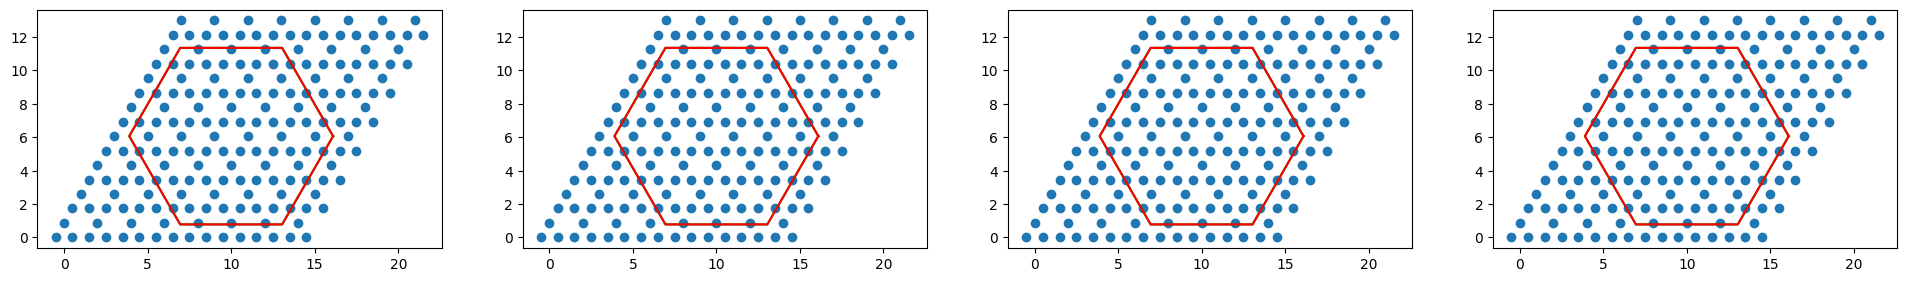

In [8]:
num_configs_loop = len(ebSpecs.polygon_ebs)
fig, axes = plt.subplots(1, num_configs_loop, figsize=(6 *num_configs_loop, 8))
for i, ax in enumerate(axes):
    ax = axes[i]
    my_x, my_y = lattice.convert_to_XY(BZ_kpoints)
    ax.scatter(my_x, my_y)
    ax.set_aspect("equal")
    x,y = polygon.exterior.xy
    polygon2 = ebSpecs.polygon_ebs[i]
    x2,y2 = polygon2.exterior.xy
    ax.plot(x,y, c='g', label="cut boundary")
    ax.plot(x2,y2, c='r', label="cut boundary")

In [9]:
BZ_kpoints_cut = lattice.get_contained_pts_poly(BZ_kpoints, polygon)

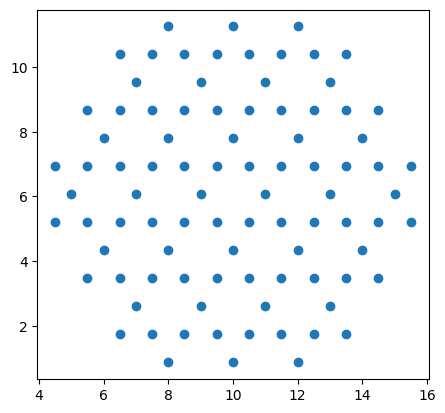

In [10]:
fig, ax = plt.subplots(1,1)
my_x, my_y = lattice.convert_to_XY(BZ_kpoints_cut)
ax.scatter(my_x, my_y)
ax.set_aspect("equal")

Text(0.5, 0.98, 'Lattice with N=90 and $N_{\\rm bonds}=$162')

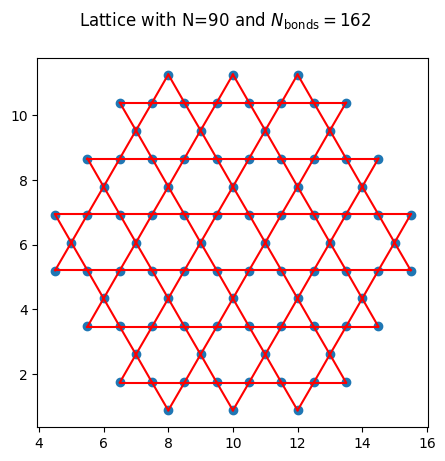

In [11]:
bonds_nn = bonds._find_all_bonds(BZ_kpoints_cut)
fig, ax = plt.subplots(1,1)
# my_x, my_y = zip((np.stack(BZ_kpoints_cut, 0)[:, 0], np.stack(BZ_kpoints_cut, 0)[:, 1]))
ax.scatter(my_x, my_y)
ax.set_aspect("equal")
plot_utils._plot_v_bonds(ax, bonds_nn, c='r')
fig.suptitle(f"Lattice with N={my_x[0].shape[0]} and " +r"$N_{\rm bonds}=$" + f"{bonds_nn.shape[0]}")


In [12]:
ListEB_comb = bonds.get_elementaryLoops((nx, ny), 'na', LatticeSpecs, ebSpecs)
ListEBs = sum(ListEB_comb, [])
num_ebs_list = [len(ebs) for ebs in ListEB_comb]
total_num_EBs = len(ListEBs)

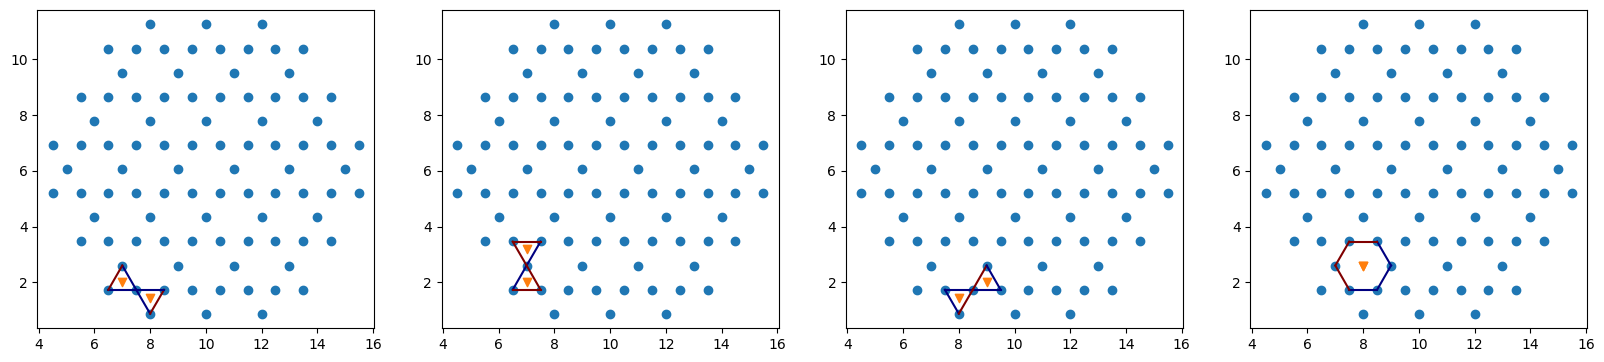

In [13]:
num_config_loops = len(ebSpecs.unit_cell_bases_ebs)
fig, axes = plt.subplots(1,num_config_loops, figsize = (num_config_loops * 5, 5 * 1), squeeze=False)

for i, ebs in enumerate(ListEB_comb):
  ax = axes[0, i]
  ax.scatter(my_x, my_y)
  for j, eb in enumerate(ebs[:1]):
    triangles = np.split(eb['triangles'], 2, axis=1)
    bd_vs = eb['bd_vs']
    # print(bd_vs.shape)
    mid_vs = eb['mid_vs']
    bd_signs = eb['bd_signs']
    
    colors = plt.cm.jet(np.linspace(0,1,2))
    bd_signs_idx = ((bd_signs + 1.)/2).astype(int)
    # print(bd_signs_idx)
    c = colors[bd_signs_idx]
    ax.scatter(triangles[0], triangles[1], marker='v')
    plot_utils._plot_v_bonds(ax, bd_vs, c=c)
#     plot_utils._plot_v_bonds(ax, mid_vs, c='r')
    ax.set_aspect("equal")

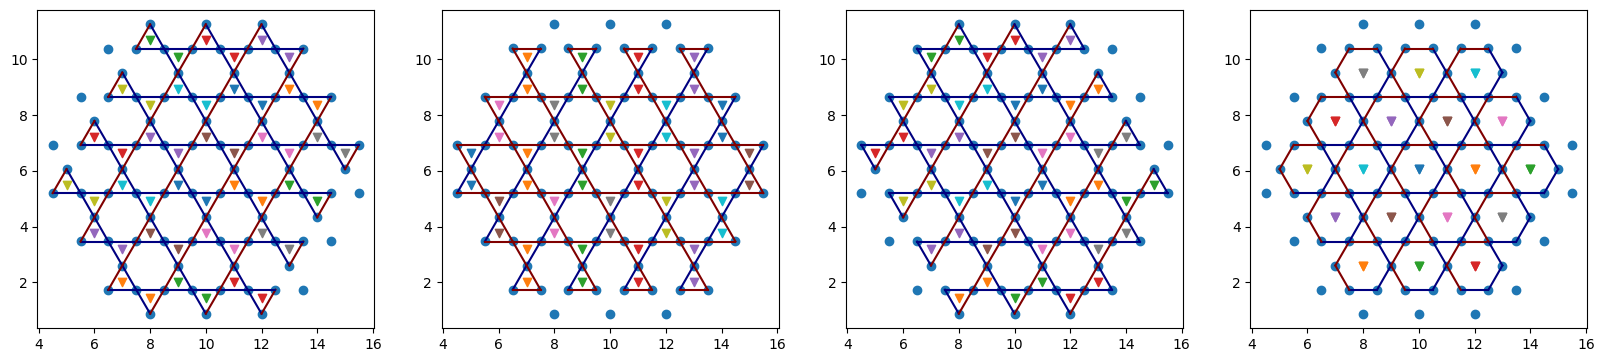

In [14]:
fig, axes = plt.subplots(1,num_config_loops, figsize = (num_config_loops * 5, 5 * 1), squeeze=False)

for i, ebs in enumerate(ListEB_comb):
  ax = axes[0, i]
  ax.scatter(my_x, my_y)
  for j, eb in enumerate(ebs):
    triangles = np.split(eb['triangles'], 2, axis=1)
    bd_vs = eb['bd_vs']
    # print(bd_vs.shape)
    mid_vs = eb['mid_vs']
    bd_signs = eb['bd_signs']
    
    colors = plt.cm.jet(np.linspace(0,1,2))
    bd_signs_idx = ((bd_signs + 1.)/2).astype(int)
    # print(bd_signs_idx)
    c = colors[bd_signs_idx]
    ax.scatter(triangles[0], triangles[1], marker='v')
    plot_utils._plot_v_bonds(ax, bd_vs, c=c)
#     plot_utils._plot_v_bonds(ax, mid_vs, c='r')
    ax.set_aspect("equal")

#### Saddle point 

In [15]:
bonds_dict = utils.build_dict_bonds(bonds_nn)

In [16]:
couplings = {'alpha':1, "beta":-2, "K":-0.5}
Q_init = np.ones(len(bonds_nn))
Q0 = 1 # this should always be set as one, original idea is to start with a smaller scale of Q0, but this is not 
        # what's been implemented. TODO: fix this. 
energy_Q = lambda Q_init: utils.get_energy(couplings, Q_init, Q0, ListEBs, bonds_dict)

In [17]:
linear_constraint = LinearConstraint(np.diag(Q_init), np.zeros_like(Q_init), 5 * np.ones_like(Q_init))
# results_gs = minimize(energy_Q, Q_init, method='trust-constr',
#                constraints=linear_constraint,
#                options={'verbose': 1})
results_gs = minimize(energy_Q, Q_init)

In [18]:
print(results_gs['fun'])
print(results_gs['success'])
print(results_gs['message'])
print(results_gs['status'])
results_gs['x']

-44.68467921327436
True
Optimization terminated successfully.
0


array([0.76323916, 0.73805743, 0.76323895, 0.73805708, 0.78914443,
       0.73965987, 0.76545551, 0.76692733, 0.78914503, 0.73805772,
       0.76323947, 0.76775875, 0.7632395 , 0.76323916, 0.76545706,
       0.76692838, 0.78914549, 0.73965994, 0.76865152, 0.76715441,
       0.7686512 , 0.76715455, 0.76660139, 0.76715514, 0.76782397,
       0.76592777, 0.7686512 , 0.76692704, 0.76775836, 0.76782382,
       0.76545649, 0.76545649, 0.76323954, 0.76775805, 0.78914527,
       0.73805741, 0.7678239 , 0.76592752, 0.76660076, 0.76715528,
       0.76527545, 0.76541227, 0.76527576, 0.7654117 , 0.7652762 ,
       0.76592681, 0.76592759, 0.76527582, 0.76782461, 0.76775924,
       0.76692744, 0.76865079, 0.76323924, 0.76323932, 0.76323874,
       0.76323981, 0.76775828, 0.76782455, 0.76865072, 0.76692759,
       0.76592728, 0.76527637, 0.76527582, 0.76592704, 0.7654117 ,
       0.76527541, 0.76541145, 0.76527562, 0.76592714, 0.76782458,
       0.76715482, 0.76660114, 0.7677577 , 0.76323933, 0.73805

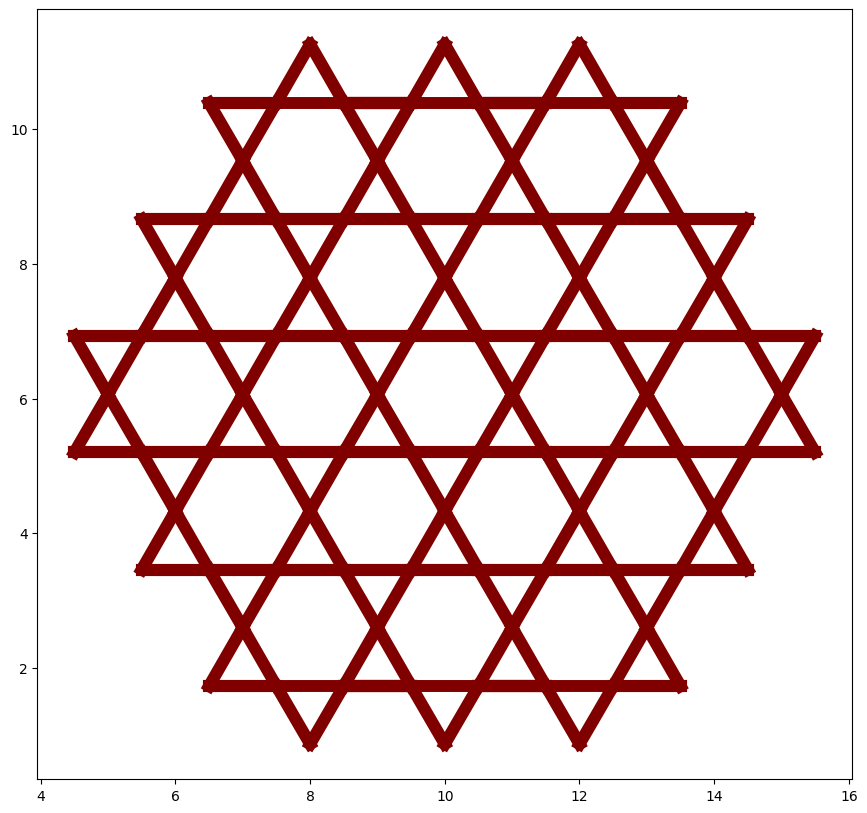

In [19]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(16, 10))
ax.scatter(my_x, my_y)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, np.zeros_like(Q_init), Q_init * results_gs['x'], c=colors[((np.sign(results_gs['x']) + 1)/2).astype(int)], p=10)
  ax.set_aspect("equal")
  ax.annotate(r"$\bar{Q}^0=$" + f"{np.mean(results_gs['x']):.2f}", (2., 5.5), size=25)
  # ax.annotate(f"thickness" + r"$\sim \sqrt{||Q^0_{ij}| - |Q^v_{ij}||}$", (1.5, 4.5), color='r', size = 15)
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')

#### vison pairs


In [60]:

# visonSpecs = bonds.Visons(
#     v_pt=np.array([7, 5 * height]),
#     visonBonds_vs = [np.array([[7.5, 4 * height], [8., 5 * height]]),
#                  np.array([[7.5, 4 * height], [8.5, 4. * height]]), 
#               np.array([[8.5, 4. * height], [9.,  3 * height]]), 
#               np.array([[9.,  3 * height], [9.5, 4 *height]]), 
#               np.array([[10.5, 2 *height], [11, 3 * height]]),
#               ]
# )              
visonSpecs = bonds.Visons(
    # v_pt=np.array([11, 19/3 * height]),
    v_pt=np.array([[11, 8],[5 * height, 25/3 * height]]),
    visonBonds_vs = [
                 np.array([[7.5, 8 * height], [8.5, 8. * height]]), 
              np.array([[8.5, 8. * height], [9.,  7 * height]]), 
              np.array([[9.,  7 * height], [9.5, 8 *height]]), 
              np.array([[10.5, 6 *height], [11, 7 * height]]),
                     np.array([[10.5, 6 *height], [11.5, 6 * height]]),
              ]
)              
visonBonds_idx = []
# print(f"initial value of Q_init is {Q_init}")
Q_flip = copy.copy(Q_init)
for bd_v in visonSpecs.visonBonds_vs:
  bd_v = np.around (bd_v, 2)
  idx = bonds_dict[str(bd_v)]
  Q_flip[idx] = -1
  visonBonds_idx.append(idx)

# print(f"final value of Q_init is {Q_init}")

In [61]:
Q_init

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.])

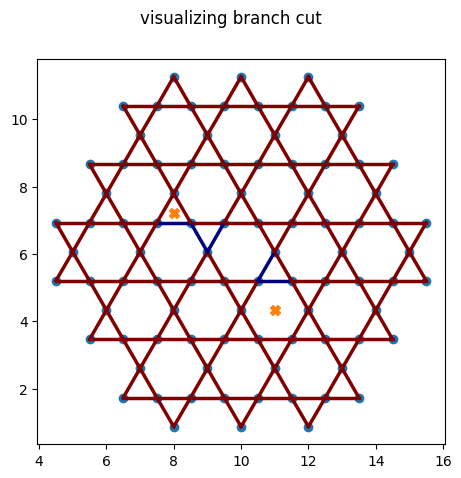

In [62]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
# Q_flip = Q_init
# print(Q_init)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, np.zeros_like(Q_flip), Q_flip, c=colors[((Q_flip + 1)/2).astype(int)], p=2.5)
  ax.scatter(*visonSpecs.v_pt, marker="X", s=50.)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 2.5))
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')
  plt.suptitle("visualizing branch cut")

In [37]:
bonds_dict

{'[[7.5  1.73]\n [6.5  1.73]]': 0,
 '[[7.5  1.73]\n [8.5  1.73]]': 1,
 '[[7.5  1.73]\n [8.   0.87]]': 2,
 '[[7.5  1.73]\n [7.   2.6 ]]': 3,
 '[[9.5  1.73]\n [8.5  1.73]]': 4,
 '[[ 9.5   1.73]\n [10.5   1.73]]': 5,
 '[[ 9.5   1.73]\n [10.    0.87]]': 6,
 '[[9.5  1.73]\n [9.   2.6 ]]': 7,
 '[[11.5   1.73]\n [10.5   1.73]]': 8,
 '[[11.5   1.73]\n [12.5   1.73]]': 9,
 '[[11.5   1.73]\n [12.    0.87]]': 10,
 '[[11.5   1.73]\n [11.    2.6 ]]': 11,
 '[[13.5   1.73]\n [12.5   1.73]]': 12,
 '[[13.5   1.73]\n [13.    2.6 ]]': 13,
 '[[6.5  3.46]\n [5.5  3.46]]': 14,
 '[[6.5  3.46]\n [7.5  3.46]]': 15,
 '[[6.5  3.46]\n [7.   2.6 ]]': 16,
 '[[6.5  3.46]\n [6.   4.33]]': 17,
 '[[8.5  3.46]\n [7.5  3.46]]': 18,
 '[[8.5  3.46]\n [9.5  3.46]]': 19,
 '[[8.5  3.46]\n [9.   2.6 ]]': 20,
 '[[8.5  3.46]\n [8.   4.33]]': 21,
 '[[10.5   3.46]\n [ 9.5   3.46]]': 22,
 '[[10.5   3.46]\n [11.5   3.46]]': 23,
 '[[10.5   3.46]\n [11.    2.6 ]]': 24,
 '[[10.5   3.46]\n [10.    4.33]]': 25,
 '[[12.5   3.46]\n [11.5  

In [38]:
results_gs['x']

array([0.76323916, 0.73805743, 0.76323895, 0.73805708, 0.78914443,
       0.73965987, 0.76545551, 0.76692733, 0.78914503, 0.73805772,
       0.76323947, 0.76775875, 0.7632395 , 0.76323916, 0.76545706,
       0.76692838, 0.78914549, 0.73965994, 0.76865152, 0.76715441,
       0.7686512 , 0.76715455, 0.76660139, 0.76715514, 0.76782397,
       0.76592777, 0.7686512 , 0.76692704, 0.76775836, 0.76782382,
       0.76545649, 0.76545649, 0.76323954, 0.76775805, 0.78914527,
       0.73805741, 0.7678239 , 0.76592752, 0.76660076, 0.76715528,
       0.76527545, 0.76541227, 0.76527576, 0.7654117 , 0.7652762 ,
       0.76592681, 0.76592759, 0.76527582, 0.76782461, 0.76775924,
       0.76692744, 0.76865079, 0.76323924, 0.76323932, 0.76323874,
       0.76323981, 0.76775828, 0.76782455, 0.76865072, 0.76692759,
       0.76592728, 0.76527637, 0.76527582, 0.76592704, 0.7654117 ,
       0.76527541, 0.76541145, 0.76527562, 0.76592714, 0.76782458,
       0.76715482, 0.76660114, 0.7677577 , 0.76323933, 0.73805

In [39]:
couplings = {'alpha':1, "beta":-2, "K":-0.5}
Q_init_vs = copy.copy(results_gs['x'])
Q0 = 1 # this should always be set as one, original idea is to start with a smaller scale of Q0, but this is not 
        # what's been implemented. TODO: fix this. 
for idx in visonBonds_idx:
  Q_init_vs[idx] = -1 * Q_init_vs[idx]
energy_Q = lambda Q_init_vs: utils.get_energy(couplings, Q_init_vs, Q0, ListEBs, bonds_dict)
linear_constraint = LinearConstraint(np.diag(Q_flip), np.zeros_like(Q_init_vs),  5 * np.ones_like(Q_init_vs))
results_vison = minimize(energy_Q, Q_init_vs, method='trust-constr',
               constraints=linear_constraint,
               options={'verbose': 1})
# results_vison = minimize(energy_Q, Q_init, bounds=einops.repeat(np.array([-10, 5]), 'a -> r a', r=len(Q_init)), options={'maxiter':1}, method="CG")

`xtol` termination condition is satisfied.
Number of iterations: 157, function evaluations: 36675, CG iterations: 2624, optimality: 5.74e-07, constraint violation: 0.00e+00, execution time: 9.3e+02 s.


In [40]:
energy_Q(Q_init)

-26.5

In [41]:
print(results_vison['fun'])
print(results_vison['success'])
print(results_vison['message'])
print(results_vison['status'])
results_vison['x']

-44.55535235978973
True
`xtol` termination condition is satisfied.
2


array([ 0.76321614,  0.73785255,  0.76319885,  0.73787269,  0.78939856,
        0.73862921,  0.76573886,  0.76606252,  0.79301682,  0.73707939,
        0.76353115,  0.77104549,  0.76353123,  0.76353123,  0.76553669,
        0.76701323,  0.78917555,  0.73981393,  0.76922281,  0.7704622 ,
        0.77288133,  0.76675162,  0.7827059 ,  0.83562778,  0.78388211,
        0.83473156,  0.78467593,  0.77018675,  0.7710456 ,  0.78388109,
        0.76573869,  0.76573871,  0.76352057,  0.76928956,  0.78928171,
        0.74003102,  0.76396283,  0.77351634,  0.76761674,  0.76998681,
        0.7646621 ,  0.78302667,  0.7815295 ,  0.76631039, -0.83443596,
        0.78204306,  0.83473011,  0.7816549 ,  0.77100587,  0.76791828,
        0.76605447,  0.77281722,  0.76319934,  0.76319942,  0.76333335,
        0.76333335,  0.76518683,  0.72732074,  0.72159662,  0.76956972,
       -0.60288918,  0.72544718, -0.72534849,  0.60317759,  0.76228102,
        0.76972985,  0.77030457,  0.7616786 ,  0.76509001,  0.76

In [42]:
Q_init

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [43]:
results_gs['x']

array([0.76323916, 0.73805743, 0.76323895, 0.73805708, 0.78914443,
       0.73965987, 0.76545551, 0.76692733, 0.78914503, 0.73805772,
       0.76323947, 0.76775875, 0.7632395 , 0.76323916, 0.76545706,
       0.76692838, 0.78914549, 0.73965994, 0.76865152, 0.76715441,
       0.7686512 , 0.76715455, 0.76660139, 0.76715514, 0.76782397,
       0.76592777, 0.7686512 , 0.76692704, 0.76775836, 0.76782382,
       0.76545649, 0.76545649, 0.76323954, 0.76775805, 0.78914527,
       0.73805741, 0.7678239 , 0.76592752, 0.76660076, 0.76715528,
       0.76527545, 0.76541227, 0.76527576, 0.7654117 , 0.7652762 ,
       0.76592681, 0.76592759, 0.76527582, 0.76782461, 0.76775924,
       0.76692744, 0.76865079, 0.76323924, 0.76323932, 0.76323874,
       0.76323981, 0.76775828, 0.76782455, 0.76865072, 0.76692759,
       0.76592728, 0.76527637, 0.76527582, 0.76592704, 0.7654117 ,
       0.76527541, 0.76541145, 0.76527562, 0.76592714, 0.76782458,
       0.76715482, 0.76660114, 0.7677577 , 0.76323933, 0.73805

In [44]:
Q0_results = results_gs['x']
Qv_results = results_vison['x']

In [45]:
Q0_results

array([0.76323916, 0.73805743, 0.76323895, 0.73805708, 0.78914443,
       0.73965987, 0.76545551, 0.76692733, 0.78914503, 0.73805772,
       0.76323947, 0.76775875, 0.7632395 , 0.76323916, 0.76545706,
       0.76692838, 0.78914549, 0.73965994, 0.76865152, 0.76715441,
       0.7686512 , 0.76715455, 0.76660139, 0.76715514, 0.76782397,
       0.76592777, 0.7686512 , 0.76692704, 0.76775836, 0.76782382,
       0.76545649, 0.76545649, 0.76323954, 0.76775805, 0.78914527,
       0.73805741, 0.7678239 , 0.76592752, 0.76660076, 0.76715528,
       0.76527545, 0.76541227, 0.76527576, 0.7654117 , 0.7652762 ,
       0.76592681, 0.76592759, 0.76527582, 0.76782461, 0.76775924,
       0.76692744, 0.76865079, 0.76323924, 0.76323932, 0.76323874,
       0.76323981, 0.76775828, 0.76782455, 0.76865072, 0.76692759,
       0.76592728, 0.76527637, 0.76527582, 0.76592704, 0.7654117 ,
       0.76527541, 0.76541145, 0.76527562, 0.76592714, 0.76782458,
       0.76715482, 0.76660114, 0.7677577 , 0.76323933, 0.73805

In [46]:
Q_init_vs

array([ 0.76323916,  0.73805743,  0.76323895,  0.73805708,  0.78914443,
        0.73965987,  0.76545551,  0.76692733,  0.78914503,  0.73805772,
        0.76323947,  0.76775875,  0.7632395 ,  0.76323916,  0.76545706,
        0.76692838,  0.78914549,  0.73965994,  0.76865152,  0.76715441,
        0.7686512 ,  0.76715455,  0.76660139,  0.76715514,  0.76782397,
        0.76592777,  0.7686512 ,  0.76692704,  0.76775836,  0.76782382,
        0.76545649,  0.76545649,  0.76323954,  0.76775805,  0.78914527,
        0.73805741,  0.7678239 ,  0.76592752,  0.76660076,  0.76715528,
        0.76527545,  0.76541227,  0.76527576,  0.7654117 , -0.7652762 ,
        0.76592681,  0.76592759,  0.76527582,  0.76782461,  0.76775924,
        0.76692744,  0.76865079,  0.76323924,  0.76323932,  0.76323874,
        0.76323981,  0.76775828,  0.76782455,  0.76865072,  0.76692759,
       -0.76592728,  0.76527637, -0.76527582,  0.76592704,  0.7654117 ,
        0.76527541,  0.76541145,  0.76527562,  0.76592714,  0.76

Text(0.5, 0.98, 'Visualizing signs of $Q_v$')

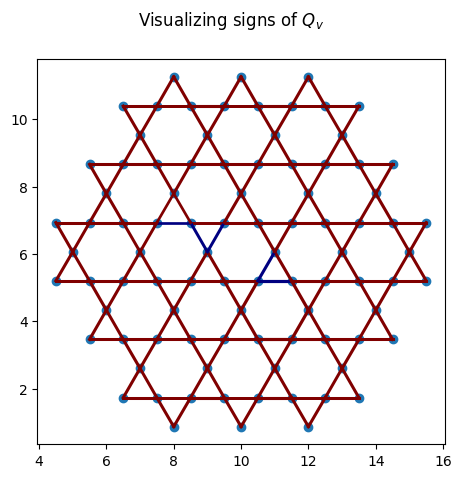

In [47]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, np.zeros_like(Qv_results), Qv_results, c=colors[((np.sign(Qv_results) + 1)/2).astype(int)], p=2.5)
  ax.set_aspect("equal")
  # ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 2.5))
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')
plt.suptitle(f"Visualizing signs of $Q_v$")  

In [48]:
Qv_results - Q0_results

array([-2.30185920e-05, -2.04877311e-04, -4.00934729e-05, -1.84388815e-04,
        2.54126399e-04, -1.03065686e-03,  2.83352576e-04, -8.64808564e-04,
        3.87178928e-03, -9.78333544e-04,  2.91675549e-04,  3.28674199e-03,
        2.91731757e-04,  2.92069947e-04,  7.96303259e-05,  8.48410047e-05,
        3.00570302e-05,  1.53992628e-04,  5.71287580e-04,  3.30778827e-03,
        4.23012938e-03, -4.02927250e-04,  1.61045168e-02,  6.84726353e-02,
        1.60581418e-02,  6.88037872e-02,  1.60247299e-02,  3.25971141e-03,
        3.28724525e-03,  1.60572694e-02,  2.82197696e-04,  2.82216569e-04,
        2.81027824e-04,  1.53150668e-03,  1.36443178e-04,  1.97360236e-03,
       -3.86107283e-03,  7.58882297e-03,  1.01597487e-03,  2.83152355e-03,
       -6.13343167e-04,  1.76143982e-02,  1.62537339e-02,  8.98689626e-04,
       -1.59971216e+00,  1.61162496e-02,  6.88025186e-02,  1.63790784e-02,
        3.18125891e-03,  1.59043773e-04, -8.72975450e-04,  4.16642910e-03,
       -3.98948733e-05, -

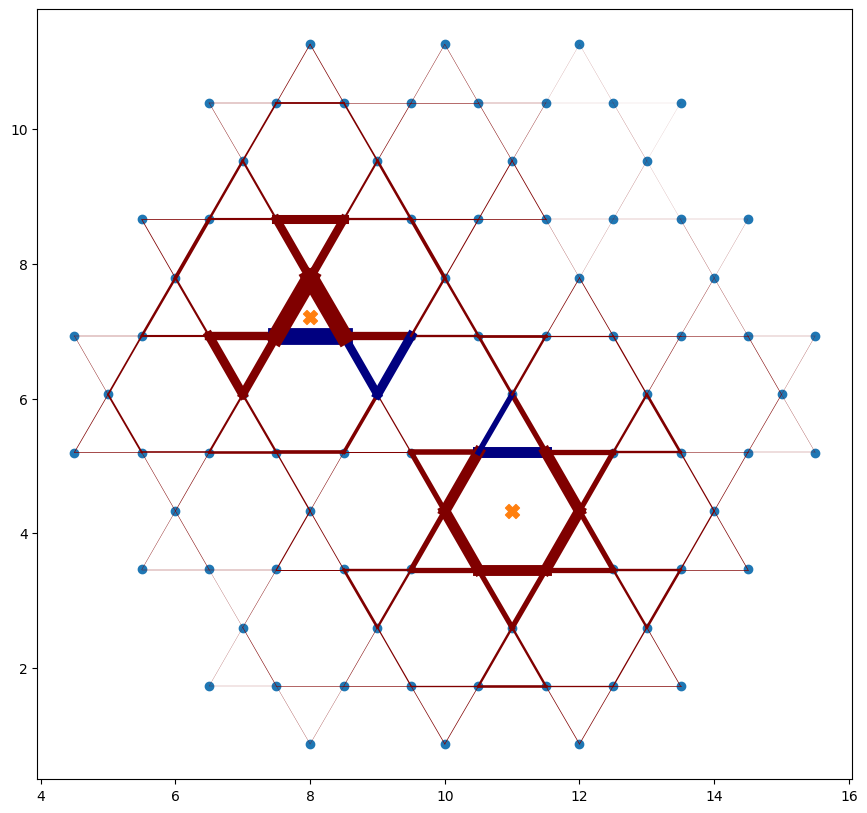

In [63]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(16, 10))
ax.scatter(my_x, my_y)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, Q0_results, Q_flip * Qv_results, c=colors[((np.sign(Qv_results) + 1)/2).astype(int)], p=30)
  ax.scatter(*visonSpecs.v_pt, marker="X", s=100)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (2., 5.5), size=25)
  ax.annotate(f"thickness" + r"$\sim \sqrt{|Q^0_{ij} - Q^v_{ij}|}$", (1.5, 4.5), color='r', size = 15)
  ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')